## Local Outlier Factor (LOF)
* Effective Unsupervised Learning Method for outlier detection.
* Density-based technique that uses the nearest-neighbor search to identify anomalous points.
* An outlier can be a local outlier or a global outlier. A data point is considered an outlier if it is far away from the body of the data in its neighborhood but maybe it is not an outlier if one looks at the entire data universe.
* Specially useful when data has varying densities.


<img src = "../figures/lof.png">

The red point is a local outlier, and the gray points are global outliers.

### Prepare the data set

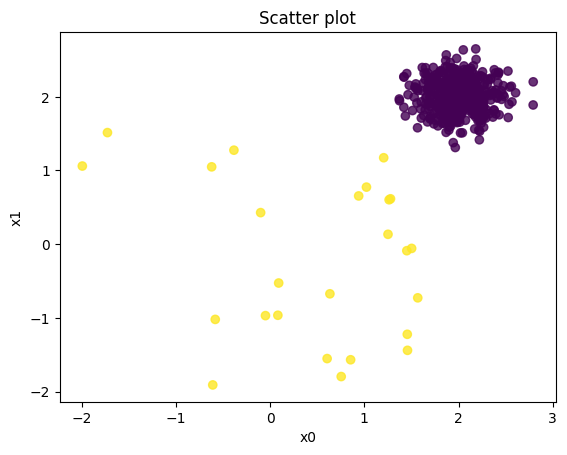

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils_od import count_stat, confusion_matrix, confusion_matrix_threshold,plot_data ,descriptive_stat_threshold 
from pyod.utils.data import generate_data

contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Build the model
* LOF computes the density deviation of a data point with respect to its neighbors.
* An outlier has substantially lower density than its neighbors.
* The red point is in a much less dense area than the dark blue neighbors.
* Steps:
- - K-neighbors. Determine the area containing closest k-neighbors data points.
- - K-distance. Compute distance from current point to the K-nearest data point.
- - Reachability-Distance (RD). Max value of {distance between any point P and current point, K-distance}. The higher this value, more chances to be an outlier.
- - Local reachability density (LRD). Is the inverse of the average RD of current point from its neighbors. Low values indicate closest data body is far from current point.
- - Local Outlier Facor of K-neighbor: LOF(k):
- - - Compare data point density against density of closest cluster. 
- - - Is the ratio of the average LRD of the K neighbors of crrent point to its LRD.
- - - If current point is not an outlier, the average LRD of neighbors is approx. equal to the LRD of current point. So LOF is nearly equal to 1.
- - - Instead if LOF > 1, the current data point is considered an outlier.

In [3]:
from pyod.models.lof import LOF
lof = LOF(contamination=0.05) 
lof.fit(X_train)

# Training data
y_train_scores = lof.decision_function(X_train)
y_train_pred = lof.predict(X_train)

# Test data
y_test_scores = lof.decision_function(X_test)
y_test_pred = lof.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , lof.threshold_)

The training data: {0: 477, 1: 23}
The training data: {0: 472, 1: 28}
The threshold for the defined contamination rate: 1.321258785666126


In [4]:
lof.get_params()

{'algorithm': 'auto',
 'contamination': 0.05,
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 20,
 'novelty': True,
 'p': 2}

### Determine the threshold visually

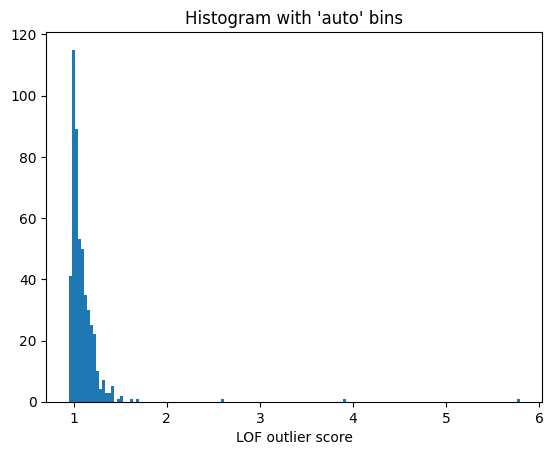

In [4]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('LOF outlier score')
plt.show()

1.5 seems a reasonable threshold.

### Step 3: Descriptive statistics

In [9]:
threshold = lof.threshold_ # Or other value from the above histogram
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,477,95.4,1.94,1.92,1.90,1.89,1.92,1.9,1.07
1,Outlier,23,4.6,1.58,1.46,1.53,1.71,1.54,1.5,1.77


In [6]:
confusion_matrix_threshold(y_train, y_train_scores, lof.threshold_)

Pred,0,1
Actual,,
0.0,458,17
1.0,19,6


In [7]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,455,20
1.0,17,8


### Aggregate Model Predictions to Achieve Stability


In [10]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.lof import LOF
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 models.
n_clf = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 
 120, 130, 140, 150, 160, 170, 180, 190, 200]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    lof = LOF(n_neighbors=k) 
    lof.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = lof.decision_scores_
    test_scores[:, i] = lof.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

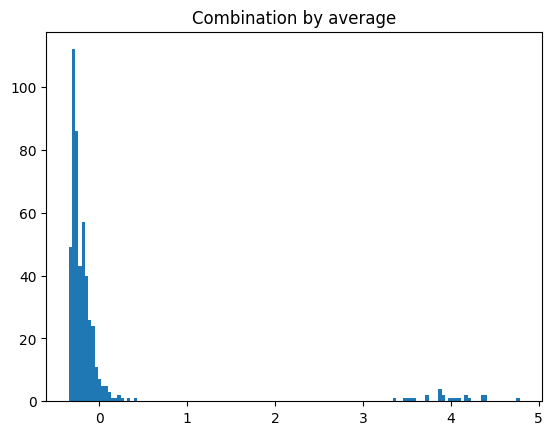

In [11]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [15]:
threshold_by_avg = .6
descriptive_stat_threshold(X_train,y_train_by_average, threshold_by_avg)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,-0.21
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,3.97


In [16]:
descriptive_stat_threshold(X_test,y_test_by_average, threshold_by_avg)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.02,2.01,2.01,1.99,2.01,2.00,-0.21
1,Outlier,25,5.0,0.00,-0.54,-0.23,-0.05,-0.06,0.12,3.81


In [17]:
confusion_matrix_threshold(y_train, y_train_by_average, threshold_by_avg)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


## Summary LOF
* Density-based approach that uses neighbor search to identify anomalous points.
* if LOF > 1, an instance is considered an outlier.